In [1]:

import sys
sys.path.append('../')
from data_read import *
from utils import *
from net import *
import matplotlib.pyplot as plt
from backbone.backboneUtils import  *
import numpy as np
import pandas as pd
import argparse

import os


In [2]:



parser = argparse.ArgumentParser()

parser.add_argument('--dataset_name', action="store", dest= "dataset_name",default="SkyData",help='SkyData')
parser.add_argument('--epoch_eval', action="store", dest="epoch_eval", type=int, default=10,help='eval from which epoch')
parser.add_argument('--samples_to_test', action="store", dest="samples_to_test", type=int, default=20,help='samples to test')

parser.add_argument('--batch_size', action="store", dest="batch_size", type=int, default=16, help='batch_size')
parser.add_argument('--backbone', action="store", dest="backbone", type=int, default=6,help='backbone')



input_parameters = parser.parse_args([])



In [3]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:

save_path='./checkpoints/'+input_parameters.dataset_name+'/'


**Test Model**

In [5]:
#backbone
load_path_backbone = './backbone/model/'

backbone_input = ResNet_first_input()
backbone_template = ResNet_first_template()

backbone_input.load_weights(load_path_backbone + 'epoch_' + str(input_parameters.backbone) + "input_full")
backbone_template.load_weights(load_path_backbone + 'epoch_' + str(input_parameters.backbone) + "template_full")

#head
regression_network=Net_first()
regression_network.load_weights(save_path + 'epoch_'+str(input_parameters.epoch_eval))


In [6]:

if input_parameters.dataset_name=='SkyData':
    data_loader_caller=data_loader_SkyData('val')

7990


In [7]:
file = open("./results/Results.txt","w")


errors = []
error_homography=[]
error_ace=[]
error_total=[]


#samples_to_test=data_loader_caller.datasetSize()
samples_to_test=input_parameters.samples_to_test
for iters in range(samples_to_test):
    input_img,u_list,v_list,template_img=data_loader_caller.data_read_batch(batch_size=1)
    if len(np.shape(input_img))<2:
        break
## stage 1
    input_feature_one = backbone_input.call(input_img, training=False)
    template_feature_one = backbone_template.call(template_img, training=False)

    ## stage 2


    input_img_grey=input_feature_one
    template_feature_one=template_feature_one
    template_img_grey = tf.image.pad_to_bounding_box(template_feature_one, 32, 32, 192, 192)

    network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
    #ready network input

    homography_vector=regression_network.call(network_input,training=False)
    gt_vector=gt_motion_rs(u_list,v_list,batch_size=1)
    homography_loss= tf.reduce_mean(tf.math.sqrt((homography_vector-gt_vector)**2))

    corner_error=corner_loss(1,homography_vector,u_list,v_list)
    loss= homography_loss + corner_error*0.001

    showcase={
        "sample":iters,

        "input_fmap":{
            "input":input_img
        },

        "template_fmap":{
            "template":template_img
        },
        "H":{
            "gt_vector":gt_vector,
            "predicted":homography_vector
        },
        "UV":{
            "u_list":u_list,
            "v_list":v_list
        },
        "corner_error":corner_error
    }

    #detailAndLog(showcase)
    registerAndSave(pileAndConcatenate(showcase))



    errors.append(np.float(corner_error))
    
    logs = f"s:{iters}  ace:{corner_error}  h_loss:{homography_loss}"
    file.write(logs)
    file.write('\n')

file.close()


ErrorDict= {"error": errors}

dtframedf = pd.DataFrame(ErrorDict)
dtframedf.to_csv('./results/Results.csv')

creating one


# Visualize feature maps

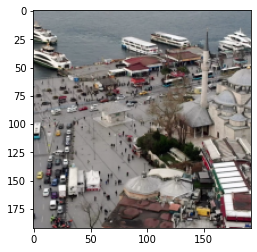

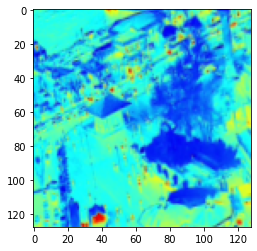

In [9]:
plt.imshow(input_img[0,:,:,:3])
plt.show()

plt.imshow(template_img[0,:,:,:3])
plt.show()
